In [2]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
from dask.distributed import Client
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import ffschema, sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
from tqdm.notebook import tqdm

In [3]:
samples_nano = [
    "TTJets",
    
    "4mu_500GeV_5p0GeV_0p08mm",
    "4mu_500GeV_5p0GeV_0p8mm",
    "4mu_500GeV_5p0GeV_8p0mm",
    "4mu_500GeV_5p0GeV_40p0mm",
    "4mu_500GeV_5p0GeV_80p0mm",
]

In [4]:
fileset = utilities.make_fileset(samples_nano, "llpNanoAOD_v2", max_files=1)

runner = processor.Runner(
    executor=processor.IterativeExecutor(),
    #executor=processor.FuturesExecutor(),
    schema=NanoAODSchema,
    #maxchunks=1,
)

channels = ["base"]
p = sidm_processor.SidmProcessor(
    channels,
    ["base"],
    lj_reco_choices=["0.4"],
    llpnanoaod=True,
)

output = runner.run(fileset, treename="Events", processor_instance=p)
out = output["out"]

Output()

Output()

/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered 
in divide
  result = getattr(ufunc, method)(

/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in
divide
  result = getattr(ufunc, method)(

#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'LJ_PT', 
'Matched_Jet_PT', 'weight']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'LJ_PT', 
'Matched_Jet_PT', 'weight']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'LJ_PT', 
'Matched_Jet_PT', 'weight']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'LJ_PT', 
'Matched_Jet_PT', 'weight']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'LJ_PT', 
'Matched_Jet_PT', 'weight']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'LJ_PT', 
'Matched_Jet_PT', 'weight']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'LJ_PT', 
'Matched_Jet_PT', 'weight']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'LJ_PT', 
'Matched_Jet_PT', 'weight']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'LJ_PT', 
'Matched_Jet_PT', 'weight']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'LJ_PT', 
'Matched_Jet_PT', 'weight']

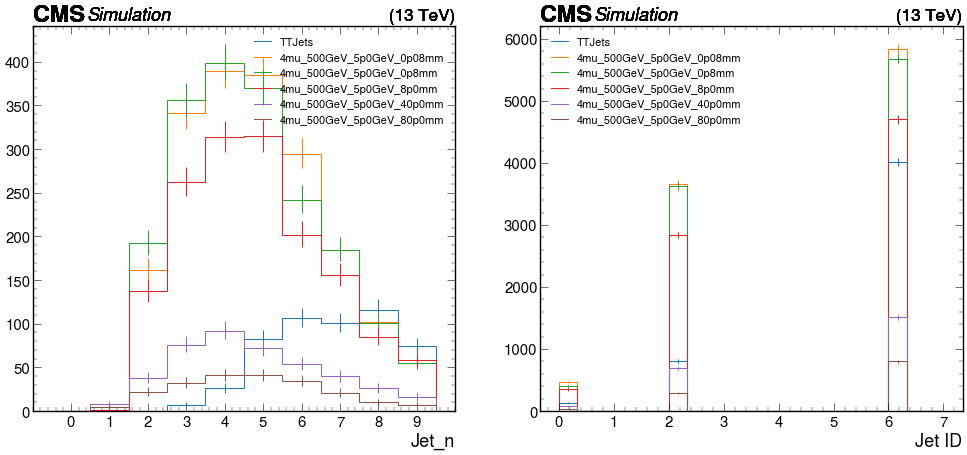

In [4]:
plt.subplots(1,2,figsize=(24,10))

plt.subplot(1,2,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet_n"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(1,2,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet_ID"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=2, prop={'size': 16})

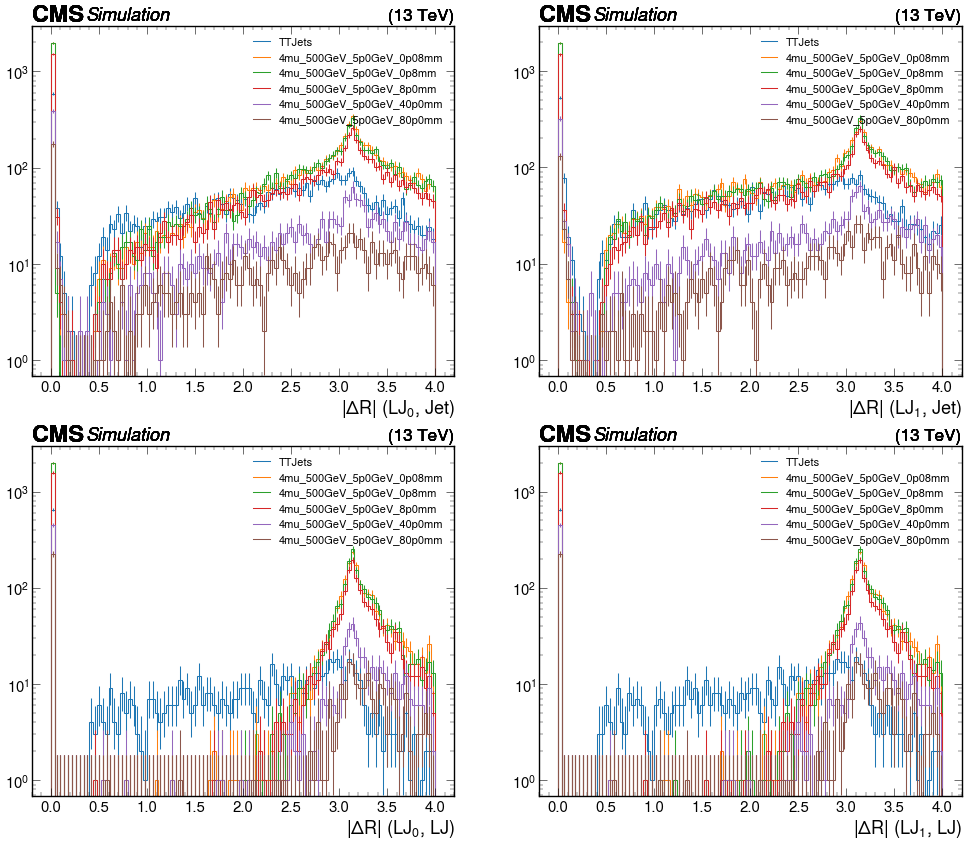

In [5]:
plt.subplots(2,2,figsize=(24,20))

plt.subplot(2,2,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj1_jet_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj2_jet_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,3)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj1_lj_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,4)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj2_lj_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

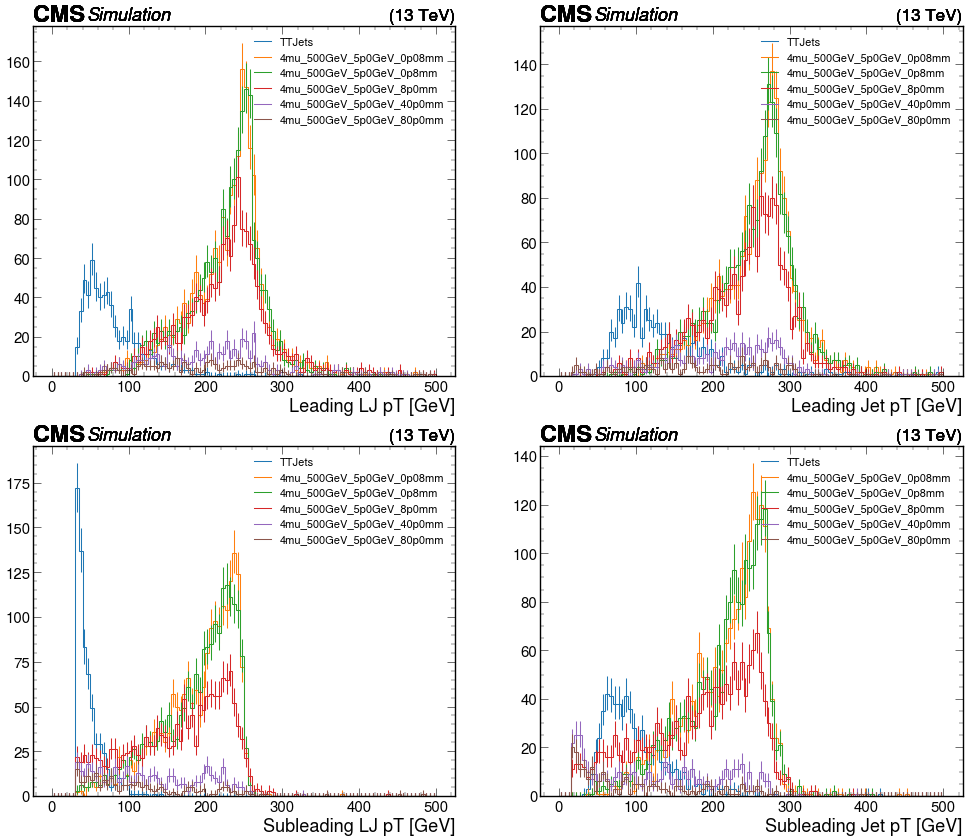

In [6]:
plt.subplots(2,2,figsize=(24,20))

plt.subplot(2,2,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj0_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(2,2,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet1_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(2,2,3)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj1_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(2,2,4)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet2_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

(0.0, 6000.0)

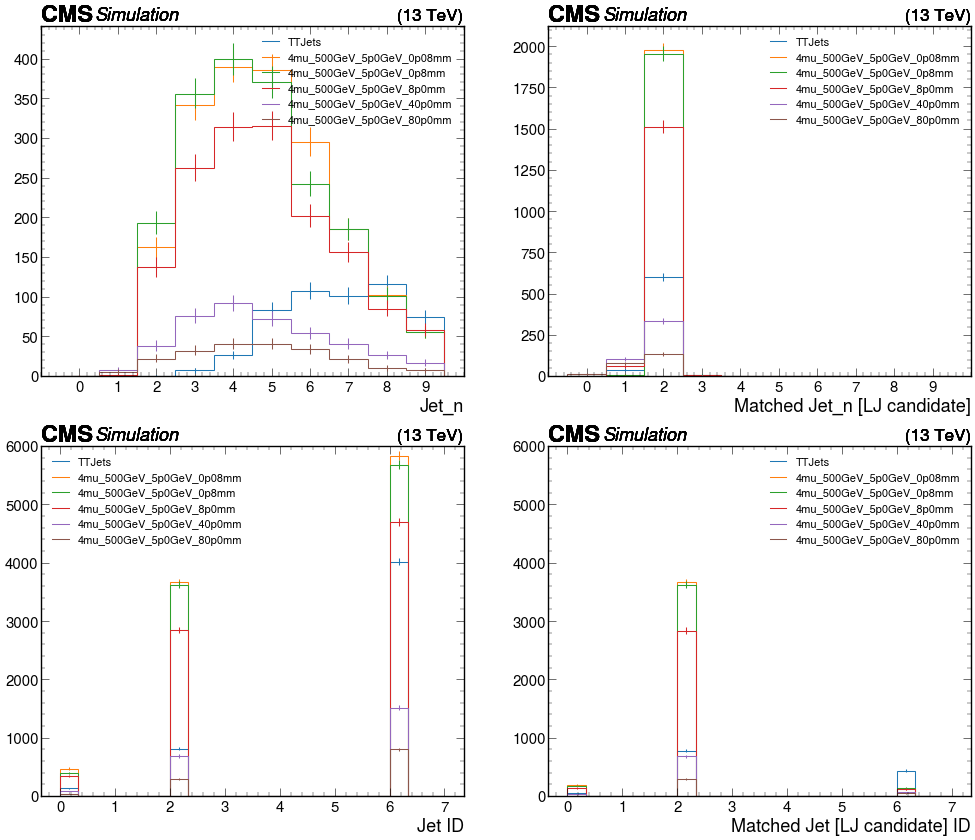

In [7]:
plt.subplots(2,2,figsize=(24,20))

plt.subplot(2,2,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet_n"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(2,2,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["matched_jet_n"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(2,2,3)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet_ID"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=2, prop={'size': 16})
plt.ylim(0, 6000)

plt.subplot(2,2,4)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["matched_jet_ID"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0, 6000)

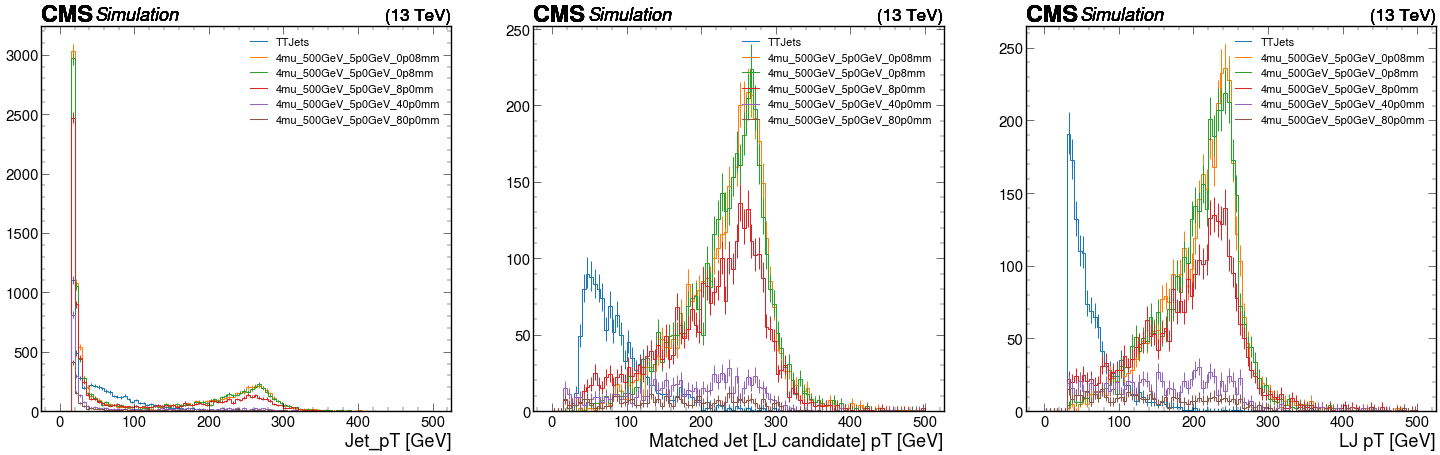

In [8]:
plt.subplots(1,3,figsize=(36,10))

plt.subplot(1,3,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(1,3,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["matched_jet_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(1,3,3)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

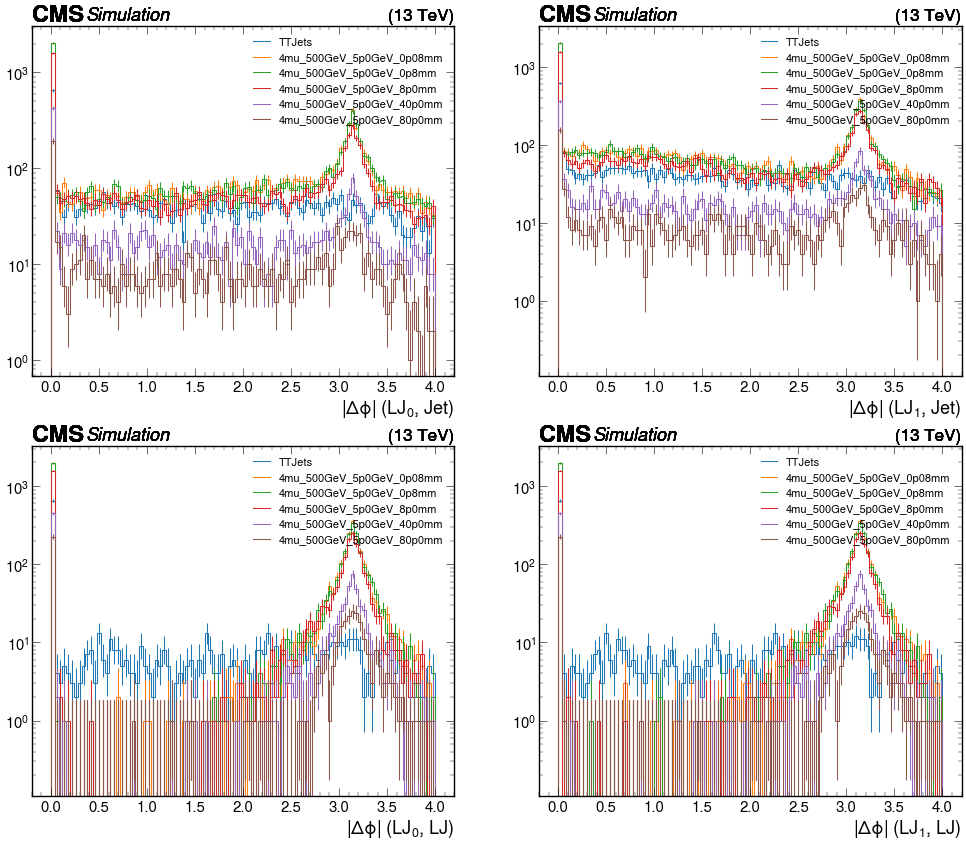

In [9]:
plt.subplots(2,2,figsize=(24,20))

plt.subplot(2,2,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj1_jet_absdphi"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj2_jet_absdphi"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,3)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj1_lj_absdphi"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,4)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj2_lj_absdphi"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

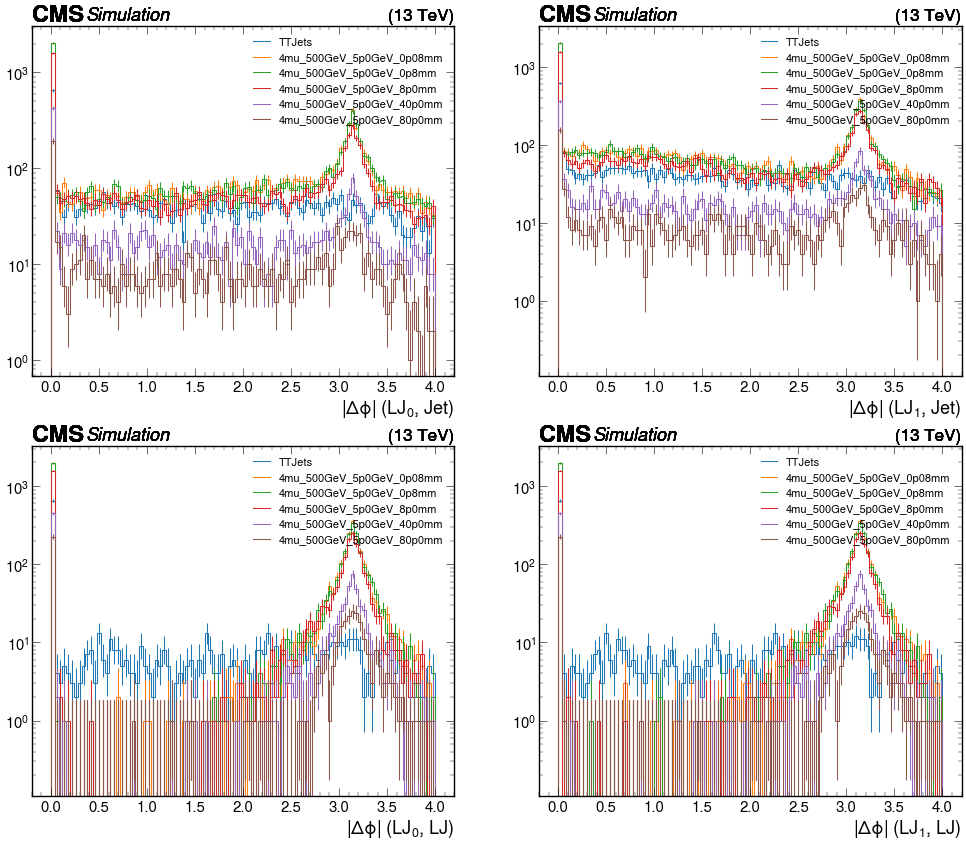

In [10]:
plt.subplots(2,2,figsize=(24,20))

plt.subplot(2,2,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj1_jet_absdphi"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj2_jet_absdphi"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,3)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj1_lj_absdphi"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,4)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj2_lj_absdphi"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

In [5]:
for sample in samples_nano:
    print("Sample: {0}".format(sample))
    print("Total # of LJs: {0}".format(out[sample]["counters"]['0.4']['base']['Total LJs']))
    print("Total # of LJs near Jets with dR 0.4: {0}".format(out[sample]["counters"]['0.4']['base']['Total LJs near Jets with 0.4']))
    print("Total # of LJs near Jets with dR 0.1: {0}".format(out[sample]["counters"]['0.4']['base']['Total LJs near Jets with 0.1']))
    print("")

Sample: TTJets
Total # of LJs: 1301
Total # of LJs near Jets with dR 0.4: 1300
Total # of LJs near Jets with dR 0.1: 1260

Sample: 4mu_500GeV_5p0GeV_0p08mm
Total # of LJs: 3971
Total # of LJs near Jets with dR 0.4: 3971
Total # of LJs near Jets with dR 0.1: 3963

Sample: 4mu_500GeV_5p0GeV_0p8mm
Total # of LJs: 3949
Total # of LJs near Jets with dR 0.4: 3948
Total # of LJs near Jets with dR 0.1: 3940

Sample: 4mu_500GeV_5p0GeV_8p0mm
Total # of LJs: 3154
Total # of LJs near Jets with dR 0.4: 3111
Total # of LJs near Jets with dR 0.1: 3095

Sample: 4mu_500GeV_5p0GeV_40p0mm
Total # of LJs: 899
Total # of LJs near Jets with dR 0.4: 802
Total # of LJs near Jets with dR 0.1: 775

Sample: 4mu_500GeV_5p0GeV_80p0mm
Total # of LJs: 449
Total # of LJs near Jets with dR 0.4: 360
Total # of LJs near Jets with dR 0.1: 347



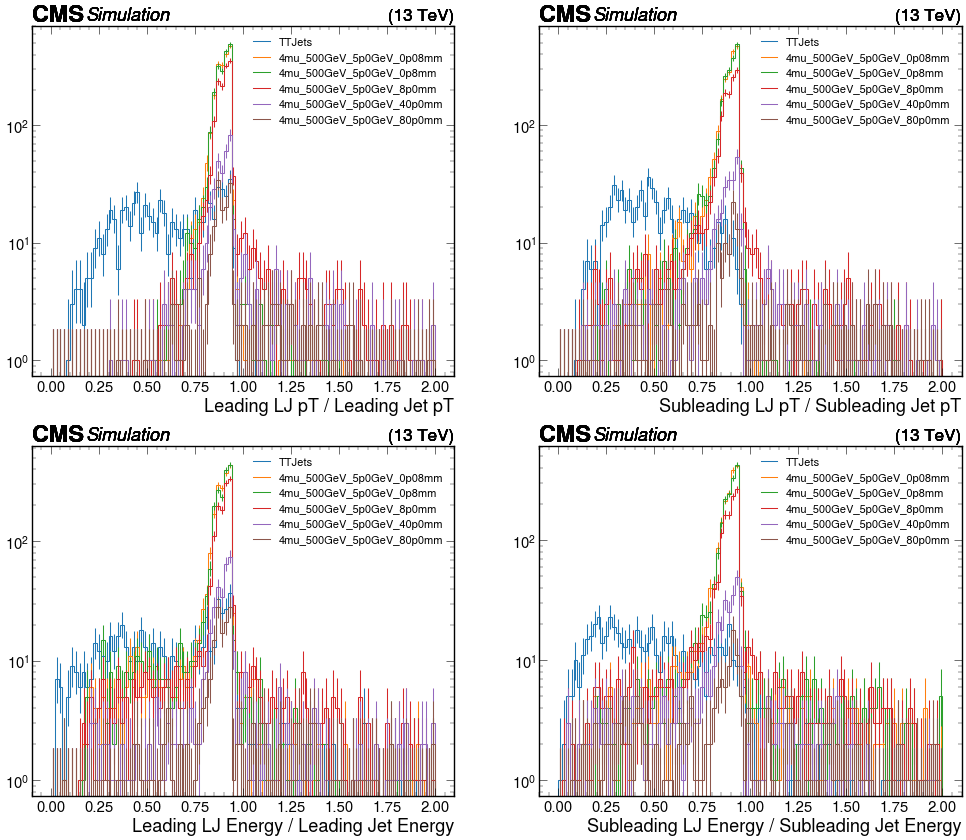

In [12]:
plt.subplots(2,2,figsize=(24,20))

plt.subplot(2,2,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["leading_LJ_pt_Jet_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["subleading_LJ_pt_Jet_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,3)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["leading_LJ_E_Jet_E"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,4)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["subleading_LJ_E_Jet_E"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

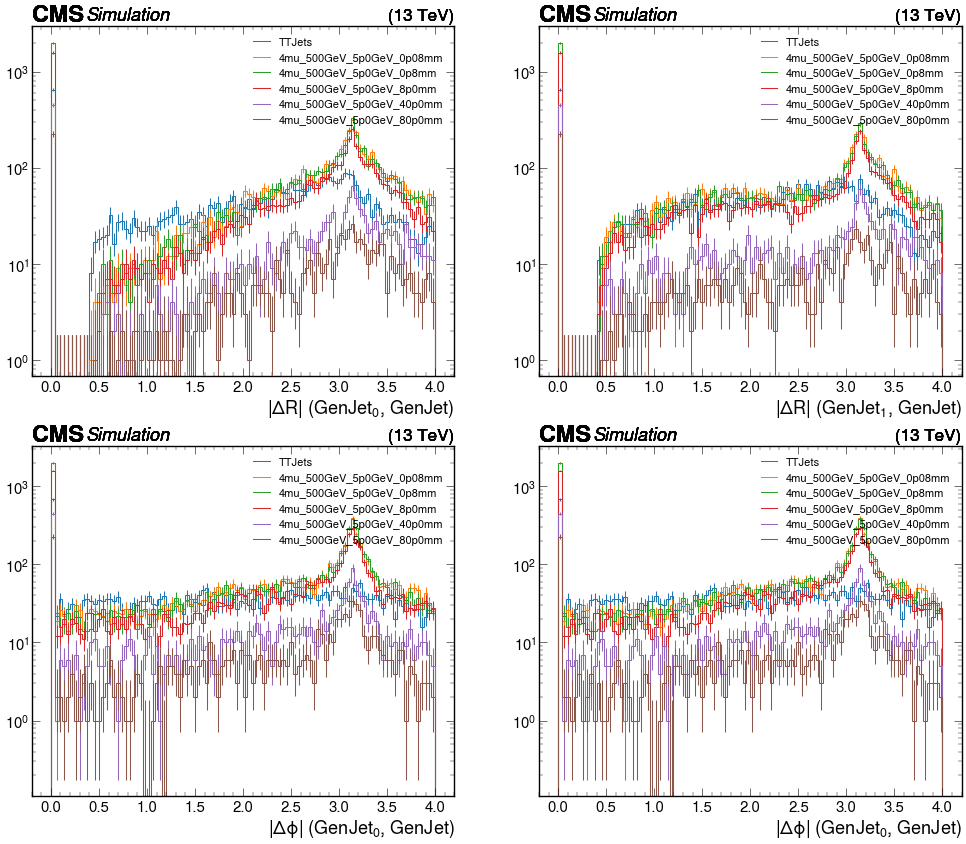

In [13]:
plt.subplots(2,2,figsize=(24,20))

plt.subplot(2,2,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["genjet1_genjet_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["genjet2_genjet_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,3)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["genjet1_genjet_absdphi"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,4)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["genjet1_genjet_absdphi"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

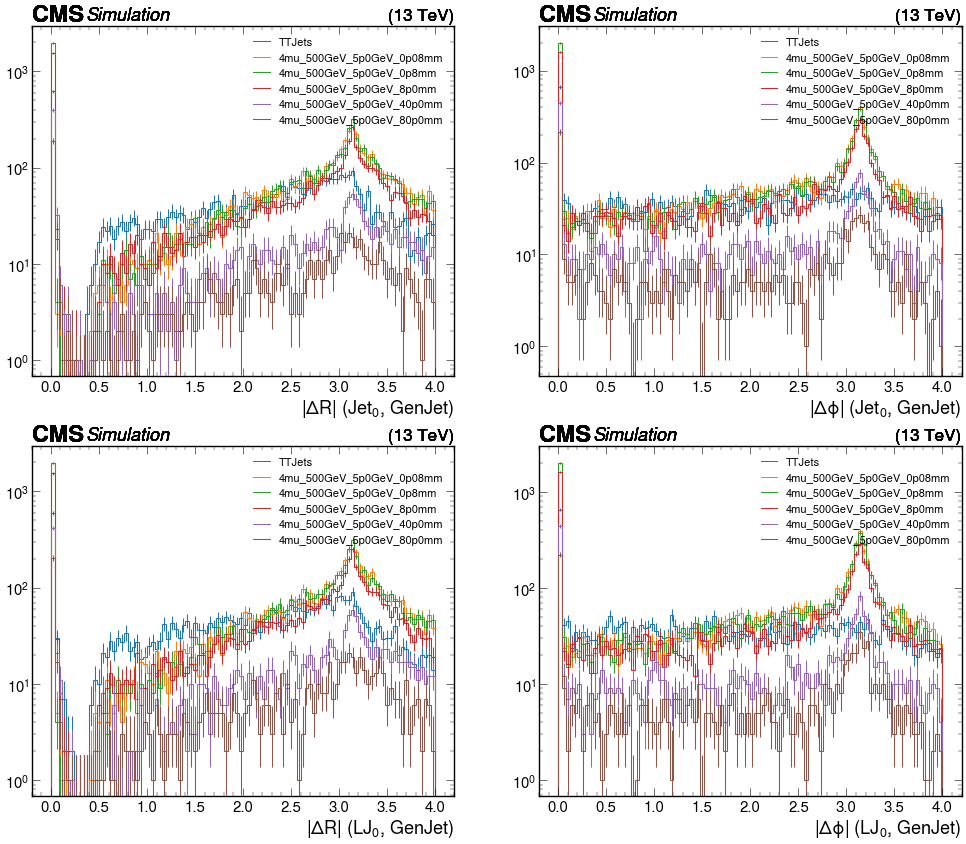

In [14]:
plt.subplots(2,2,figsize=(24,20))

plt.subplot(2,2,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet1_genjet_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet1_genjet_absdphi"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,3)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj1_genjet_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')

plt.subplot(2,2,4)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj1_genjet_absdphi"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.yscale('log')